This notebook will be used to implement and assess the following PyRosetta protocol: repack a sphere around the mutated residue, and then output a feature set consisting of 1) total structure score for all the active score terms, and 2) mutated residue scores for each of the active score terms. 

In [1]:
import pandas 
import pyrosetta 
from sklearn import preprocessing, svm, ensemble, model_selection, metrics, manifold, decomposition
from rosetta import protocols, core 
from Bio.Data import IUPACData
import matplotlib.pyplot as plt 
import numpy as np 
%matplotlib inline

In [2]:
plt.style.use('seaborn-deep')

In [3]:
pyrosetta.init('-beta')

Found rosetta database at: /Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/pyrosetta-4.0-py3.5.egg/database; using it....
PyRosetta-4 2016 [Rosetta 2016 unknown:94998f0e5b038b6d8083995a664cb96641cb844b 2017-05-11 15:10:16 -0500] retrieved from: git@github.com:RosettaCommons/main.git
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.



In [4]:
df = pandas.read_csv('../data_sets/speculative_targets.csv', index_col=0)
df.drop('BglB', axis=0, inplace=True)
df.sample(5)

,kcat,km,kcatkm,expression
mutant_name,,,,
H315A,-0.190593,-0.318759,0.133129,1
S32L,NaN,NaN,NaN,0
W34A,NaN,NaN,NaN,0
G153A,-0.114215,0.017033,-0.126285,1
W325L,-0.907056,0.059942,-0.963881,1


In [5]:
df.shape

(145, 4)

In [6]:
# for features, lets use the mutate-only set for now 

In [52]:
p = pyrosetta.pose_from_file('../rosetta_runs/bglb/relax/output/relax_387/2JIE_0001.pdb')
s = pyrosetta.create_score_function('beta_cst')
s(p)

-1396.9818086598987

In [53]:
total_score = core.scoring.score_type_from_name('total_score')
fa_rep = core.scoring.score_type_from_name('fa_rep')

In [54]:
en = p.energies()
en.total_energies()[total_score]

-1396.9818086598987

In [55]:
mutate = protocols.simple_moves.MutateResidue(399, 'ALA')
mutate.apply(p)

s(p)

-1389.479313450101

In [57]:
hood = core.select.residue_selector.NeighborhoodResidueSelector()
hood.set_focus('119')
hood.set_distance(9.23)
hood.apply(p)

vector1_bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [58]:
en = p.energies()
en.residue_total_energies(10)

In [59]:
around = protocols.toolbox.task_operations.DesignAroundOperation()
around.include_residue(119) 
around.repack_shell(16.0) 
around.resnums_allow_design(False)
around.allow_design(False)

tf = core.pack.task.TaskFactory()
tf.push_back(around) 
pt = tf.create_task_and_apply_taskoperations(p)

In [63]:
repack = protocols.simple_moves.PackRotamersMover(s, pt, 20)    
repack.apply(p)
s(p)

-1116.3896372253735

In [64]:
p = pyrosetta.pose_from_file('../rosetta_runs/bglb/relax/output/relax_387/2JIE_0001.pdb')
s = pyrosetta.create_score_function('beta_cst')
s(p)

-1396.9818086598987

In [74]:
# OK, for each mutant, we need a score 

def rosetta_score(score_type='total_score'):
    
#     def fetch_residue_scores(pose):
#         for n in range(1, pose.total_residue()):
#             for m in s.get_nonzero_weighted_scoretypes():
#                 yield pose.energies().residue_total_energies(n)[m]
    
    score_type = core.scoring.score_type_from_name(score_type)
    for mutant_name in df.index:
        # make "mutation" 
        pose = p.clone()
        native, *pos, design = mutant_name 
        pos = int(''.join(pos))
        design = IUPACData.protein_letters_1to3[design].upper()
        mutate = protocols.simple_moves.MutateResidue(pos, design) 
        _ = s(pose)
        score_begin = [pose.energies().total_energies()[n] for n in s.get_nonzero_weighted_scoretypes()] #WT
        mutate.apply(pose)
        
        # conformational sampling 
        tf = core.pack.task.TaskFactory()
        around = protocols.toolbox.task_operations.DesignAroundOperation()
        around.include_residue(pos) 
        around.repack_shell(16.0) 
        around.resnums_allow_design(False)
        around.allow_design(False)
        tf.push_back(around) 
        pt = tf.create_task_and_apply_taskoperations(pose)
        #print(pt)
        repack = protocols.simple_moves.PackRotamersMover(s, pt)
        repack.apply(pose)
        
        # scoring 
        #residue_scores = list(fetch_residue_scores(pose)) 
        #print(len(residue_scores))
        #print(residue_scores[0:])
        _ = s(pose) 
        score_end = [pose.energies().total_energies()[n] for n in s.get_nonzero_weighted_scoretypes()] #WT
        score_delta = np.array(score_end) - np.array(score_begin) # this will "just work" when these are Numpy arrays
        yield score_delta 
        #yield residue_scores  
        
list_of_score_type_names = [str(n).replace('ScoreType.', '') for n in s.get_nonzero_weighted_scoretypes()]
features = pandas.DataFrame(list(rosetta_score()), index=df.index, columns=list_of_score_type_names)
features.head()

,fa_atr,fa_rep,fa_sol,fa_intra_atr_xover4,fa_intra_rep_xover4,fa_intra_sol_xover4,lk_ball,lk_ball_iso,lk_ball_bridge,lk_ball_bridge_uncpl,...,omega,fa_dun_dev,fa_dun_rot,fa_dun_semi,p_aa_pp,hxl_tors,ref,chainbreak,rama_prepro,res_type_constraint
mutant_name,,,,,,,,,,,,,,,,,,,,,
S14A,8.010224,680.222779,-9.152645,-0.256170,14.941892,0.557818,-3.778482,-8.870141,-0.352730,-1.034677,...,0.0,-26.706606,0.387846,13.671417,0.157368,-0.221230,2.61774,0.0,0.852206,0.0
T15A,20.390279,660.972584,-6.243333,-0.827020,51.721633,0.974664,-5.476304,-14.351413,-0.009325,0.789701,...,0.0,-28.749258,-1.027680,12.496848,1.760430,-3.307373,2.92680,0.0,2.471956,0.0
S16A,14.224435,448.563157,-3.480427,-0.332181,46.882355,0.425772,4.416269,-9.015683,-0.174726,-1.375214,...,0.0,-27.505135,-1.153862,11.567442,0.202147,-0.318688,2.61774,0.0,0.728249,0.0
S17A,5.900023,453.138921,-5.736437,-1.071418,53.068120,1.576934,-1.220134,-6.631476,0.146638,0.358086,...,0.0,-31.350005,-1.578429,14.493174,-0.057944,0.413531,2.61774,0.0,-0.526123,0.0
S17E,-1.972401,601.230771,10.841259,-1.775335,53.932236,2.822280,4.246609,6.216775,0.055827,-0.553277,...,0.0,-31.350005,-1.578429,23.415145,-0.212568,-0.596261,-1.95646,0.0,-0.892448,0.0


In [75]:
features.shape

(145, 32)

In [76]:
# clean up features a bit 
drop_me = []
for feature in features:
    if features[feature].std() == 0.0:
        drop_me.append(feature)

features.drop(drop_me, axis=1, inplace=1) 
features.shape

(145, 26)

**Result: dropping features with `variance == 0.0` reduces feature count from 32 to 26**. This leaves sample size (145) unchanged. 

In [77]:
J = df[['expression']].join(features) 
J.head()

,expression,fa_atr,fa_rep,fa_sol,fa_intra_atr_xover4,fa_intra_rep_xover4,fa_intra_sol_xover4,lk_ball,lk_ball_iso,lk_ball_bridge,...,hbond_sc,dslf_fa13,omega,fa_dun_dev,fa_dun_rot,fa_dun_semi,p_aa_pp,hxl_tors,ref,rama_prepro
mutant_name,,,,,,,,,,,,,,,,,,,,,
A192S,1,4.312361,220.950196,5.410598,0.185173,5.360243,0.103128,1.643984,1.128287,-0.098004,...,10.017116,0.000000,0.0,-21.445490,2.022555,9.573517,0.777252,0.136906,-2.61774,0.672233
A227W,1,-9.682471,49.881750,4.857922,-1.877781,12.161073,1.210802,0.767017,5.389842,-0.123823,...,2.978943,0.000000,0.0,-7.438384,0.000000,9.420368,0.848380,0.151961,-0.14880,0.148422
A236E,0,-9.207879,1823.058559,14.500062,-1.029504,5.388277,1.955699,4.394745,10.762358,-0.192617,...,5.948159,0.000000,0.0,-9.496867,0.788509,8.137878,-0.109442,0.153803,-4.57420,-0.303618
A249E,0,2.951922,106.868789,9.224902,0.201512,4.763525,0.292381,-0.288437,1.579625,0.293019,...,8.591722,0.000000,0.0,-19.095985,3.925874,6.905658,-0.480354,0.138921,-4.57420,-0.255901
C167A,1,4.706897,346.022170,-2.300191,-0.420129,39.765354,0.536075,3.089860,-1.140032,-0.275309,...,7.386049,0.374325,0.0,-23.884382,0.782602,11.191530,-0.666514,0.555805,-1.78020,-0.542907


In [78]:
from scipy import stats 

We are interested in: for each of the features, is there a significant difference between the feature for proteins that express and proteins that do not express? 

In [79]:
for feature in J.columns[1:]:
    ks = stats.ks_2samp(J.query('expression==0')[feature], J.query('expression==1')[feature])
    if ks.statistic > 0.0:
        print(ks)
        print(feature)

Ks_2sampResult(statistic=0.16330737517178198, pvalue=0.40709744433895745)
fa_atr
Ks_2sampResult(statistic=0.3060009161704077, pvalue=0.0077090257455020572)
fa_rep
Ks_2sampResult(statistic=0.28950984883188274, pvalue=0.013809661697717811)
fa_sol
Ks_2sampResult(statistic=0.206367384333486, pvalue=0.15953909426684929)
fa_intra_atr_xover4
Ks_2sampResult(statistic=0.3573064590013742, pvalue=0.0010224507426407001)
fa_intra_rep_xover4
Ks_2sampResult(statistic=0.18735684837379751, pvalue=0.24843755698499762)
fa_intra_sol_xover4
Ks_2sampResult(statistic=0.2240036646816308, pvalue=0.10170689867368085)
lk_ball
Ks_2sampResult(statistic=0.19880897846999535, pvalue=0.19127597546375136)
lk_ball_iso
Ks_2sampResult(statistic=0.10558863948694452, pvalue=0.89525821197018651)
lk_ball_bridge
Ks_2sampResult(statistic=0.12826385707741642, pvalue=0.71325095856805643)
lk_ball_bridge_uncpl
Ks_2sampResult(statistic=0.15666513971598717, pvalue=0.45998689096816303)
fa_elec
Ks_2sampResult(statistic=0.17246907924874

**K-S analysis points to `lk_ball_bridge` and `fa_intra_rep_xover4` as informative features.** Based on p-value around 0.05.

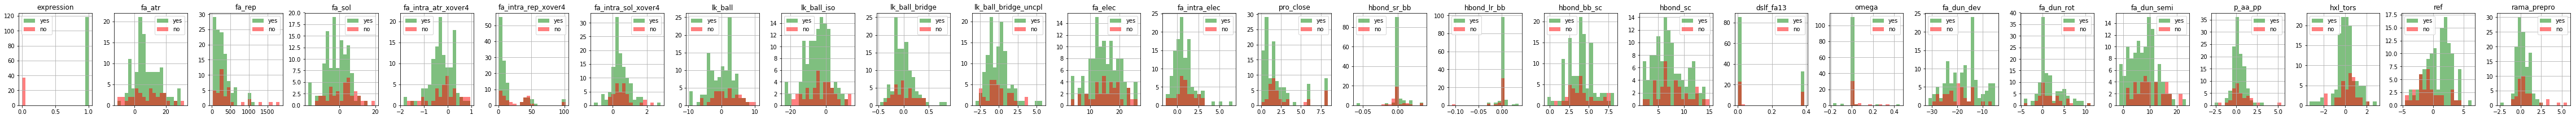

In [80]:
plot = J.columns #['fa_rep', 'fa_atr', 'omega'] 
fig, ax = plt.subplots(nrows=1, ncols=len(plot), figsize=(3*len(plot), 3))
for n, f in enumerate(plot):
    bins = np.linspace(J[f].min(), J[f].max(), 20)
    J[(J.expression==1)].hist(f, color='green', ax=ax[n], bins=bins, alpha=0.5)
    J[(J.expression==0)].hist(f, color='red', ax=ax[n], bins=bins, alpha=0.5)
    ax[n].legend(['yes', 'no'])

**Analysis of the experimental data**. We have data for 145 proteins, of which about 40 do not express and about 105 do express, making for a slightly unbalanced data set. 

In [97]:
# machine learning targets (scale X and y is actually unchanged) 
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(J.iloc[:, 1:])
y = J.iloc[:, 0].ravel()
X.shape, y.shape

((155, 26), (155,))

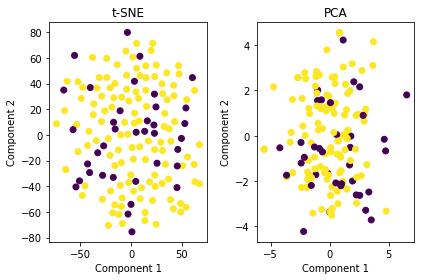

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=2)

tsne = manifold.TSNE()
reduced = tsne.fit_transform(X, y) 
ax[0].scatter(reduced[:, 0], reduced[:, 1], c=y) 
ax[0].set(title='t-SNE', xlabel='Component 1', ylabel='Component 2') 

pca = decomposition.PCA(n_components=2)
reduced = pca.fit_transform(X, y) 
ax[1].scatter(reduced[:, 0], reduced[:, 1], c=y) 
ax[1].set(title='PCA', xlabel='Component 1', ylabel='Component 2')

fig.tight_layout()

**Analysis of the feature decomposition and t-distributed stochastic neighbor embedding**. Features decomposed into dimension of 2 do not appear to be linearly separable. We will have to use a machine learning technique. 

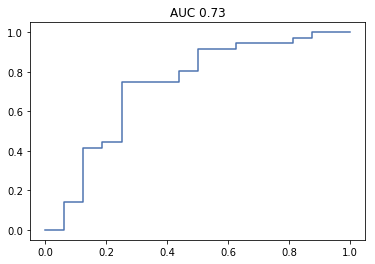

In [99]:
clf = svm.SVC(C=3, probability=1, class_weight='balanced', kernel='rbf')
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33)
clf.fit(X_train, y_train) 
pred = clf.predict(X_test)
prob = clf.predict_proba(X_test) 
fpr, tpr, _ = metrics.roc_curve(y_test, prob[:, 1], pos_label=1) 
auc = metrics.roc_auc_score(y_test, prob[:, 1]) 
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('AUC {0:2.2}'.format(auc))

In [100]:
model_selection.permutation_test_score(clf, X, y, scoring='roc_auc')

(0.58404558404558404,
 array([ 0.37991453,  0.48205128,  0.53279915,  0.59597578,  0.47859687,
         0.55099715,  0.36232194,  0.36887464,  0.56499288,  0.34700855,
         0.38376068,  0.45306268,  0.55039174,  0.49209402,  0.59519231,
         0.47460826,  0.44287749,  0.48326211,  0.44893162,  0.61082621,
         0.48230057,  0.47054843,  0.53906695,  0.49437322,  0.39284188,
         0.51225071,  0.39519231,  0.58383191,  0.37211538,  0.36378205,
         0.43785613,  0.45559117,  0.50890313,  0.49430199,  0.39294872,
         0.47396724,  0.48970798,  0.50836895,  0.45858262,  0.56527778,
         0.60320513,  0.52995014,  0.58828348,  0.33354701,  0.47418091,
         0.50373932,  0.54508547,  0.32190171,  0.49316239,  0.47674501,
         0.57496439,  0.40263533,  0.50551994,  0.43614672,  0.40787037,
         0.54159544,  0.46919516,  0.5284188 ,  0.35110399,  0.48988604,
         0.49255698,  0.40897436,  0.61819801,  0.43012821,  0.5642094 ,
         0.46876781,  0.45010

In [101]:
feature_importance = pandas.DataFrame(list(zip(clf.feature_importances_, J.columns[1:])), columns=['importance', 'feature'])
print(len(feature_importance), 'features')
feature_importance.sort_values('importance', ascending=0).head(10)

AttributeError: 'SVC' object has no attribute 'feature_importances_'

**Machine learning analysis**. We train a RBF-kernel SVM on 70% of the data set, and test on remaining 30%. ROC curve. As a very first look, this is somewhat promising, bordering on 'meh'. 

In [ ]:
from sklearn import dummy 

In [ ]:
# let's see if we can grid search for a better set of params, and do some CV as well 
clf = svm.SVC(C=10, kernel='rbf')
mean_svm_score, svm_score, pvalue = model_selection.permutation_test_score(clf, X, y, cv=10, n_jobs=-1) 

clf = dummy.DummyClassifier(strategy='stratified')
mean_dum_score, dum_score, pvalue = model_selection.permutation_test_score(clf, X, y, cv=10, n_jobs=-1)

array([ 0.63809524,  0.69833333,  0.61940476,  0.69922619,  0.5685119 ,
        0.63666667,  0.56982143,  0.62869048,  0.64083333,  0.58470238,
        0.58458333,  0.55327381,  0.65863095,  0.6252381 ,  0.63940476,
        0.56089286,  0.50696429,  0.6652381 ,  0.60994048,  0.64029762,
        0.57785714,  0.59303571,  0.66440476,  0.66666667,  0.69922619,
        0.57244048,  0.51809524,  0.69166667,  0.52071429,  0.59077381,
        0.55113095,  0.69255952,  0.65333333,  0.57345238,  0.60142857,
        0.57553571,  0.62880952,  0.61845238,  0.67119048,  0.60029762,
        0.57113095,  0.69964286,  0.62559524,  0.63714286,  0.52285714,
        0.68529762,  0.61625   ,  0.5577381 ,  0.47964286,  0.67107143,
        0.56529762,  0.62071429,  0.72416667,  0.58666667,  0.62916667,
        0.62910714,  0.53190476,  0.69922619,  0.60375   ,  0.64125   ,
        0.59666667,  0.64797619,  0.59666667,  0.59559524,  0.62434524,
        0.6072619 ,  0.57595238,  0.64029762,  0.5372619 ,  0.68

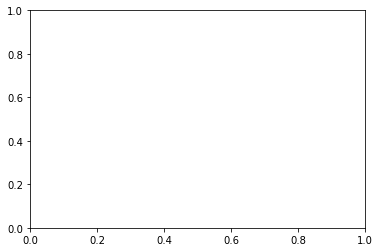

In [102]:
fig, ax = plt.subplots()
svm_score

In [103]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "RBF SVM C=10", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    SVC(C=10, kernel='rbf'), 
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(clf, score) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform') 0.692307692308
SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.711538461538
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.692307692308
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.75
GaussianProcessClassifier(copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1), max_iter_predict=100,
  

/Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


/Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


KeyboardInterrupt: 

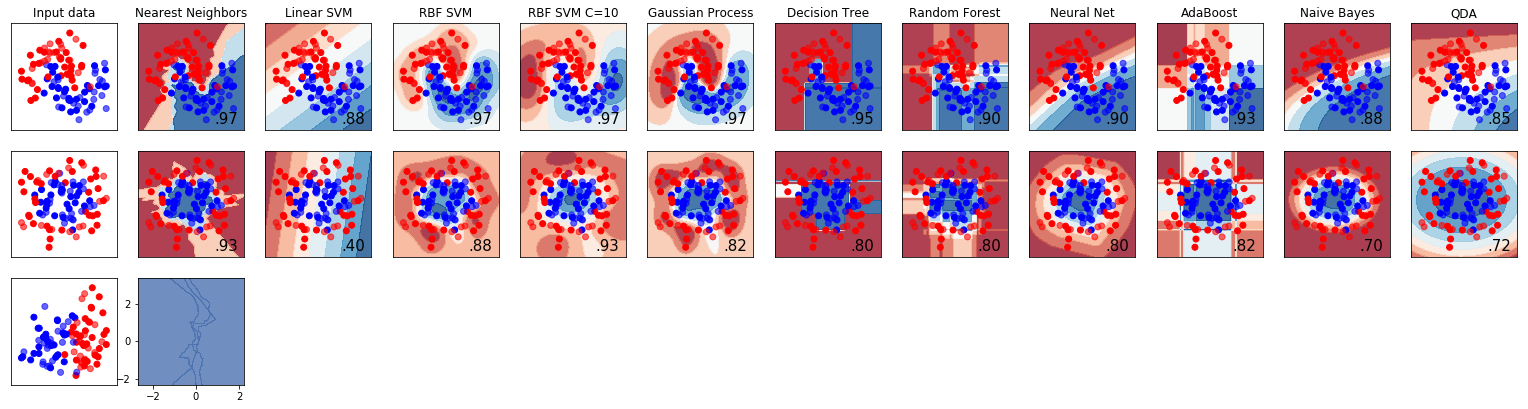

In [104]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "RBF SVM C=10", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    SVC(C=10, kernel='rbf'), 
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable, 
            real_data, 
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
    

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()